In [1]:
## LIBRARIES

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("no. of samples: %d" % n_samples)
print("no. of features: %d" % n_features)
print("no. of classes: %d" % n_classes)


Total dataset size:
no. of samples: 1288
no. of features: 1850
no. of classes: 7


In [3]:
## splitting
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)



In [4]:
n =50


pca = PCA(n_components=n, svd_solver='randomized', whiten=True)
pca.fit(X_train)


X_train_pca =pca.transform(X_train)
X_test_pca=pca.transform(X_test)


In [5]:
knn_classifier=KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_pca,y_train)

KNeighborsClassifier()

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=24241.56722885478, class_weight='balanced', gamma=0.014624503370820633)
Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.78      0.80        18
     Colin Powell       0.84      0.80      0.82        46
  Donald Rumsfeld       0.81      0.85      0.83        20
    George W Bush       0.91      0.96      0.94       106
Gerhard Schroeder       0.71      0.74      0.72        23
      Hugo Chavez       0.86      0.80      0.83        15
       Tony Blair       0.73      0.63      0.68        30

         accuracy                           0.84       258
        macro avg       0.81      0.80      0.80       258
     weighted avg       0.84      0.84      0.84       258



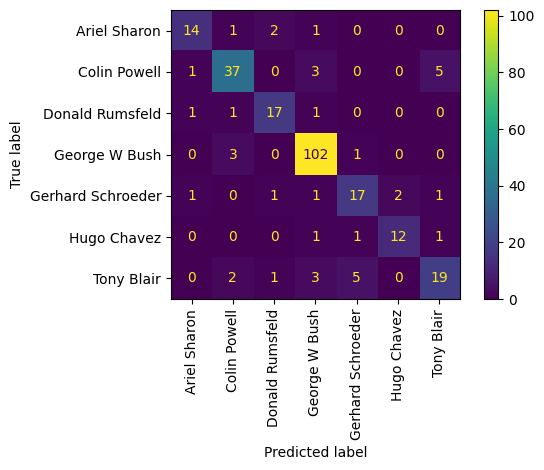

In [6]:
print("Fitting the classifier to the training set")

param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [7]:
y_pred = knn_classifier.predict(X_test_pca)

In [8]:
## report accuracy

accuracy=accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6821705426356589


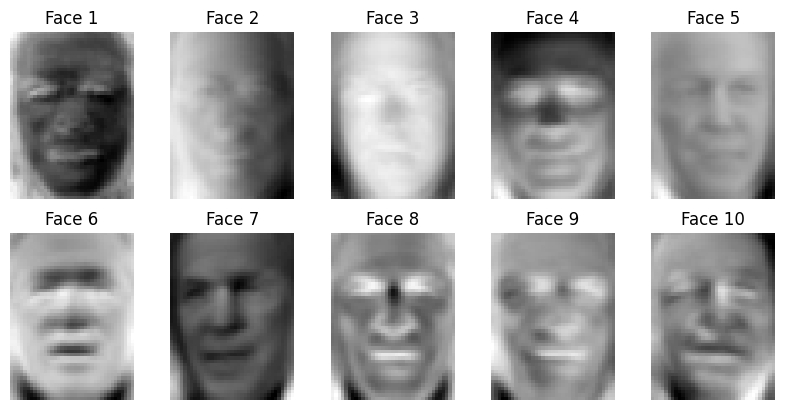

In [10]:
## visualize a subset of eigenfaces
eigenfaces = pca.components_.reshape((n, h, w))

plt.figure(figsize=(10, 10))
for iter in range(10):
    plt.subplot(4,5,iter + 1)
    plt.imshow(eigenfaces[iter], cmap=plt.cm.gray)
    plt.title(f"Face {iter+1}")
    plt.axis('off')
plt.show()


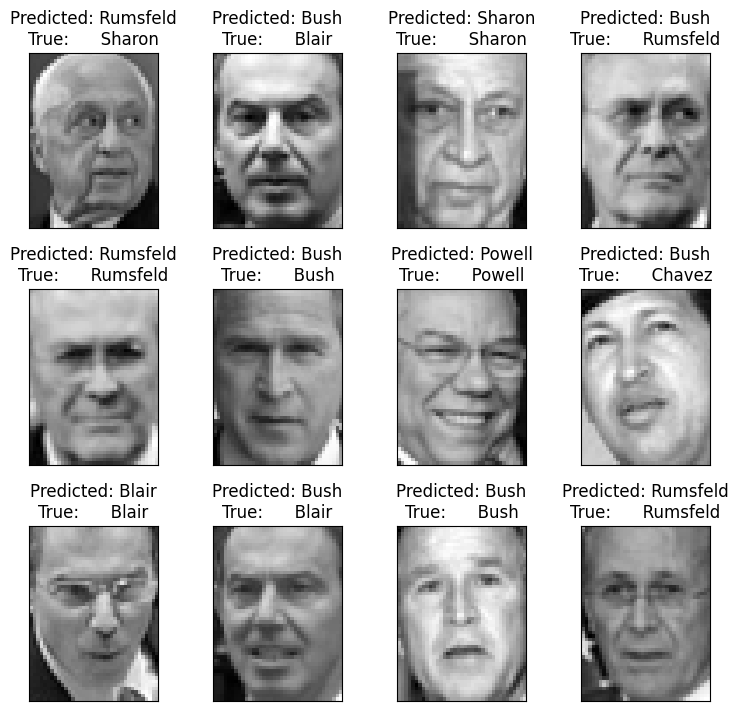

In [11]:
def plot_gallery(images, titles, height, width, n_row=3, n_col=4):
    """Helper function to plot a gallery of images"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def generate_title(predicted_labels, true_labels, target_names, index):
    predicted_name = target_names[predicted_labels[index]].rsplit(" ", 1)[-1]
    true_name = target_names[true_labels[index]].rsplit(" ", 1)[-1]
    return "Predicted: %s\nTrue:      %s" % (predicted_name, true_name)


prediction_titles = [
    generate_title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)


In [12]:
n_components_range = [90,150,200,250,300]

# Initialize lists to store results
accuracies = []

for n_components in n_components_range:
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train K-Nearest Neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = knn.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    print(f"Accuracy for n_components={n_components}: {accuracy}")

Accuracy for n_components=90: 0.5310077519379846
Accuracy for n_components=150: 0.5387596899224806
Accuracy for n_components=200: 0.5155038759689923
Accuracy for n_components=250: 0.5232558139534884
Accuracy for n_components=300: 0.5271317829457365
